<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/machine_learning_0.03/Twitter_analysis_by_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
#!apt-get update
#!apt-get install openjdk-11-jdk-headless -qq > /dev/null
#!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
#!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
#!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


In [2]:
# Download a Postgres driver that will allow Spark to interact with Postgres
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-09-01 01:46:45--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.1’

postgresql-42.2.16. 100%[===================>] 979.38K  6.30MB/s    in 0.2s    

2022-09-01 01:46:46 (6.30 MB/s) - ‘postgresql-42.2.16.jar.1’ saved [1002883/1002883]



In [3]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/twitter_sentiments.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("twitter_sentiments.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+--------------------+-------------------+--------------------+
|     username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|extractedts|is_retweet|is_quote_status|weekofyear|        cleaned_text|            negative|            neutral|            positive|
+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+--------------------+-------------------+--------------------+
|     Theo1001|      312|      123|      38156|   2008-05-14|    2022-04-22|          67|[{'text': 'StandW...|      en|             0| 2022-04-22|      true|          false|        16|thank you si

In [5]:
# Convert DataFrame to Pandas
tweets_df = text_df.toPandas()
print(tweets_df.shape)
tweets_df.head(5)

(451700, 18)


,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{'text': 'StandWithUkraine', 'indices': [106,...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{'text': 'LePen', 'indices': [28, 34]}, {'tex...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{'text': 'Mariupol', 'indices': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{'text': 'SlavaUkraini', 'indices': [30, 43]}]",en,0,2022-04-24,True,False,16,thank you,0.169791,0.608387,0.221821
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{'text': 'Ukraine', 'indices': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928


In [6]:
# Drop null values
tweets_df=tweets_df.dropna()
print(tweets_df.shape)

(83147, 18)


In [7]:
# Check data types
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83147 entries, 0 to 83147
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   username         83147 non-null  object 
 1   following        83147 non-null  int32  
 2   followers        83147 non-null  int32  
 3   totaltweets      83147 non-null  int32  
 4   usercreatedts    83147 non-null  object 
 5   tweetcreatedts   83147 non-null  object 
 6   retweetcount     83147 non-null  int32  
 7   hashtags         83147 non-null  object 
 8   language         83147 non-null  object 
 9   favorite_count   83147 non-null  int32  
 10  extractedts      83147 non-null  object 
 11  is_retweet       83147 non-null  bool   
 12  is_quote_status  83147 non-null  bool   
 13  weekofyear       83147 non-null  int32  
 14  cleaned_text     83147 non-null  object 
 15  negative         83147 non-null  float64
 16  neutral          83147 non-null  float64
 17  positive    

In [8]:
# Change the dtypes of usercreatedts, tweetcreatedts, and extractedts to datetime64 for easier operation later
tweets_df["usercreatedts"] = pd.to_datetime(tweets_df["usercreatedts"])
tweets_df["tweetcreatedts"] = pd.to_datetime(tweets_df["tweetcreatedts"])
tweets_df["extractedts"] = pd.to_datetime(tweets_df["extractedts"])

# check dtypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83147 entries, 0 to 83147
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   username         83147 non-null  object        
 1   following        83147 non-null  int32         
 2   followers        83147 non-null  int32         
 3   totaltweets      83147 non-null  int32         
 4   usercreatedts    83147 non-null  datetime64[ns]
 5   tweetcreatedts   83147 non-null  datetime64[ns]
 6   retweetcount     83147 non-null  int32         
 7   hashtags         83147 non-null  object        
 8   language         83147 non-null  object        
 9   favorite_count   83147 non-null  int32         
 10  extractedts      83147 non-null  datetime64[ns]
 11  is_retweet       83147 non-null  bool          
 12  is_quote_status  83147 non-null  bool          
 13  weekofyear       83147 non-null  int32         
 14  cleaned_text     83147 non-null  objec

In [9]:
# When were the earliest and latest tweets in this dataset created
earliest_tweet = tweets_df["tweetcreatedts"].min()
latest_tweet = tweets_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-04-22 00:00:00, and the latest was at 2022-06-13 00:00:00


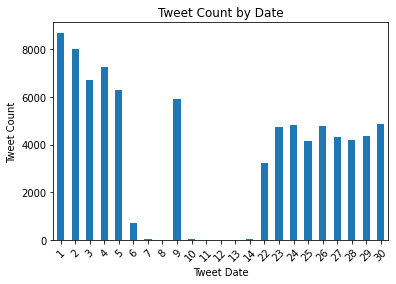

In [10]:
# Visualize tweet counts by date
# get dates in the dataframe 
dates = tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = tweets_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Change the negative score to negative value
tweets_df["negative"] = -1.0*tweets_df["negative"]
tweets_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{'text': 'StandWithUkraine', 'indices': [106,...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{'text': 'LePen', 'indices': [28, 34]}, {'tex...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,-0.004823,0.675433,0.319744
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{'text': 'Mariupol', 'indices': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{'text': 'SlavaUkraini', 'indices': [30, 43]}]",en,0,2022-04-24,True,False,16,thank you,-0.169791,0.608387,0.221821
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{'text': 'Ukraine', 'indices': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,-0.156944,0.766128,0.076928


In [12]:
# Extract negative score of twits and time, when they were created
negative_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
negative_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
1,2022-04-24,-0.004823
2,2022-04-24,-0.018234
3,2022-04-24,-0.169791
4,2022-04-22,-0.156944


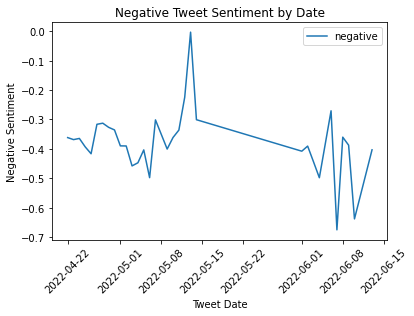

In [13]:
# Visualize negative tweet sentiment by date
# get dates in the dataframe 
dates = negative_tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean negative score for each date
negative_by_date =  negative_tweets_df.groupby([negative_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet negative sentiment by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiment by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Extract positive score of twits and time, when they were created
positive_tweets_df = tweets_df[['tweetcreatedts', 'negative']]
positive_tweets_df.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
1,2022-04-24,-0.004823
2,2022-04-24,-0.018234
3,2022-04-24,-0.169791
4,2022-04-22,-0.156944


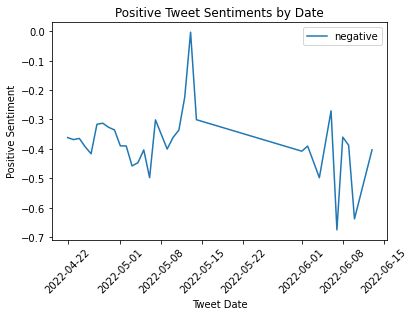

In [15]:
# Visualize positive tweet sentiment by date
# get dates in the dataframe 
dates = positive_tweets_df["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean positive score for each date
positive_by_date =  positive_tweets_df.groupby([positive_tweets_df['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_by_date.plot.line();

plt.title("Positive Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

# Analysis for Ukraine - Russia comparison


In [15]:
# Analysis for Ukraine word
ukraine_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
ukraine_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{'text': 'StandWithUkraine', 'indices': [106,...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{'text': 'Mariupol', 'indices': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457
6,berrysname,2831,2161,220797,2008-09-07,2022-04-29,465,[],en,0,2022-04-29,True,False,17,the house passed legislation to10 to allow pre...,-0.046402,0.323075,0.630523
14,greenpost,4855,4844,105613,2008-04-23,2022-04-29,78,"[{'text': 'satellite', 'indices': [22, 32]}]",en,0,2022-04-29,True,False,17,our latest imagery from this morning march 1...,-0.782127,0.209975,0.007898
22,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,24,"[{'text': 'Ukraine', 'indices': [15, 23]}]",en,0,2022-04-29,True,False,17,is today a slaughterhouse right in the heart o...,-0.003421,0.071497,0.925082


In [16]:
# Extract negative score of twits and time, when they were created
negative_for_ukraine = ukraine_df[['tweetcreatedts', 'negative']]
negative_for_ukraine.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
2,2022-04-24,-0.018234
6,2022-04-29,-0.046402
14,2022-04-29,-0.782127
22,2022-04-29,-0.003421


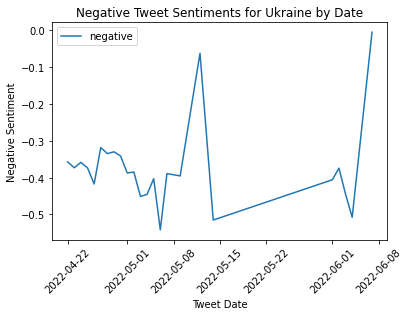

In [17]:
# Visualize tweet negative sentiment for Ukraine by date
# get dates in the dataframe 
dates = negative_for_ukraine["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean negative score for each date
negative_ukraine_by_date =  negative_for_ukraine.groupby([negative_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_ukraine_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Extract positive score of twits and time, when they were created
positive_for_ukraine = ukraine_df[['tweetcreatedts', 'positive']]
positive_for_ukraine.head(5)

,tweetcreatedts,positive
0,2022-04-22,0.270449
2,2022-04-24,0.098457
6,2022-04-29,0.630523
14,2022-04-29,0.007898
22,2022-04-29,0.925082


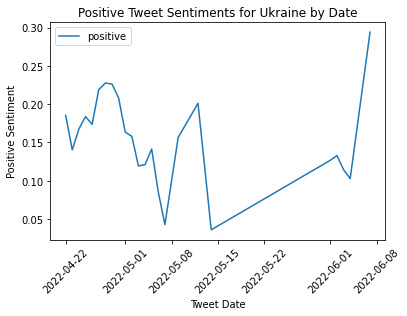

In [19]:
# Visualize tweet positive sentiment for Ukraine by date
# get dates in the dataframe 
dates = positive_for_ukraine["tweetcreatedts"].dt.day
# group tweet timestamps by date and get mean positive score for each date
positive_ukraine_by_date =  positive_for_ukraine.groupby([positive_for_ukraine['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_ukraine_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Analysis for Russia word
russia_df = tweets_df[tweets_df['cleaned_text'].str.contains('russia')]
russia_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{'text': 'Mariupol', 'indices': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457
7,ScottLucas_EA,5906,11359,147336,2008-11-07,2022-04-29,0,"[{'text': 'Russia', 'indices': [28, 35]}, {'te...",en,1,2022-04-29,False,True,17,uk military intelligence on offensive in in ea...,-0.954947,0.042540,0.002513
23,avivajazz,4990,4142,175683,2008-07-21,2022-04-29,197,[],en,0,2022-04-29,True,False,17,north kharkiv map april 30 pm ukrainian force...,-0.341673,0.615651,0.042676
24,minusone,194,166,11503,2008-02-04,2022-04-23,3,"[{'text': 'Kherson', 'indices': [54, 62]}]",en,0,2022-04-23,True,True,16,russians are stealing food from occupied,-0.035933,0.927809,0.036259
28,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,23,"[{'text': 'Kyiv', 'indices': [58, 63]}, {'text...",en,0,2022-04-29,True,False,17,kyiv russian strikes slammed into central on t...,-0.001889,0.035071,0.963041


In [21]:
# Extract negative score for Russia of twits and time, when they were created
negative_for_russia = russia_df[['tweetcreatedts', 'negative']]
negative_for_russia.head(5)

,tweetcreatedts,negative
2,2022-04-24,-0.018234
7,2022-04-29,-0.954947
23,2022-04-29,-0.341673
24,2022-04-23,-0.035933
28,2022-04-29,-0.001889


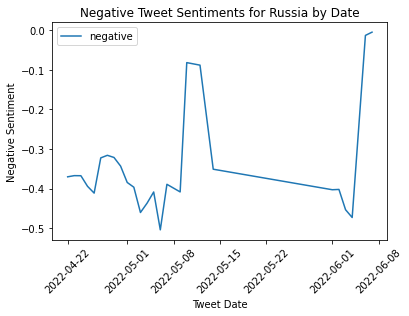

In [22]:
# Visualize negative tweet sentiment for Rossia by date
# get dates in the dataframe 
dates = negative_for_russia["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_russia_by_date =  negative_for_russia.groupby([negative_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_russia_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Russia by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Extract positive score of twits for Russia and time, when they were created
positive_for_russia = russia_df[['tweetcreatedts', 'positive']]
positive_for_russia.head(5)

,tweetcreatedts,positive
2,2022-04-24,0.098457
7,2022-04-29,0.002513
23,2022-04-29,0.042676
24,2022-04-23,0.036259
28,2022-04-29,0.963041


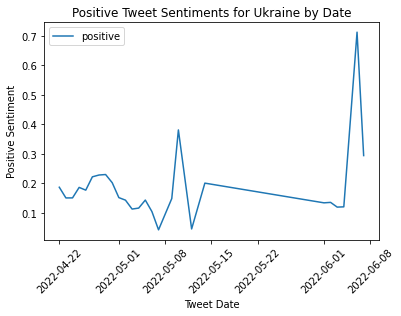

In [24]:
# Visualize tweet positive sentiment for Russia by date
# get dates in the dataframe 
dates = positive_for_russia["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average positive score for each date
positive_russia_by_date =  positive_for_russia.groupby([positive_for_russia['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_russia_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Ukraine by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

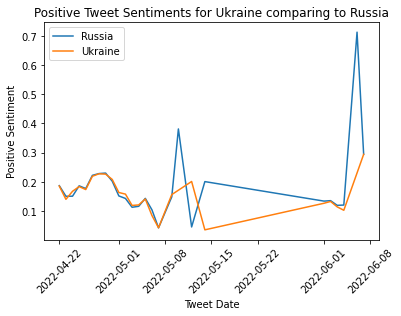

In [25]:
# The plot for Ukraine and Russia positive together
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_russia_by_date['positive'], label ='Russia')
ax.plot(positive_ukraine_by_date['positive'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()


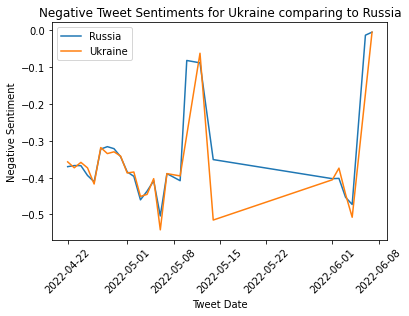

In [26]:
# The plot for Ukraine and Russia negative together
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Ukraine comparing to Russia")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_russia_by_date['negative'], label ='Russia')
ax.plot(negative_ukraine_by_date['negative'], label ='Ukraine')
plt.legend(loc="upper left")
plt.show()

# Analysis for Zelensky - Putin comparison

In [27]:
# Analysis for Zelensky word
zelensky_df = tweets_df[tweets_df['cleaned_text'].str.contains('ukraine')]
zelensky_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{'text': 'StandWithUkraine', 'indices': [106,...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,-0.010234,0.719316,0.270449
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{'text': 'Mariupol', 'indices': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,-0.018234,0.883309,0.098457
6,berrysname,2831,2161,220797,2008-09-07,2022-04-29,465,[],en,0,2022-04-29,True,False,17,the house passed legislation to10 to allow pre...,-0.046402,0.323075,0.630523
14,greenpost,4855,4844,105613,2008-04-23,2022-04-29,78,"[{'text': 'satellite', 'indices': [22, 32]}]",en,0,2022-04-29,True,False,17,our latest imagery from this morning march 1...,-0.782127,0.209975,0.007898
22,Baranduyn,3092,1654,134343,2008-05-19,2022-04-29,24,"[{'text': 'Ukraine', 'indices': [15, 23]}]",en,0,2022-04-29,True,False,17,is today a slaughterhouse right in the heart o...,-0.003421,0.071497,0.925082


In [28]:
# Extract negative score for Zelensky of twits and time, when they were created
negative_for_zelensky = zelensky_df[['tweetcreatedts', 'negative']]
negative_for_zelensky.head(5)

,tweetcreatedts,negative
0,2022-04-22,-0.010234
2,2022-04-24,-0.018234
6,2022-04-29,-0.046402
14,2022-04-29,-0.782127
22,2022-04-29,-0.003421


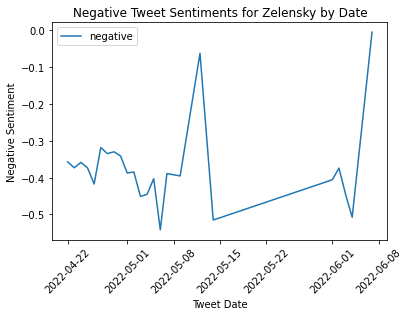

In [29]:
# Visualize negative tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = negative_for_zelensky["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_zelensky_by_date =  negative_for_zelensky.groupby([negative_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_zelensky_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [30]:
# Extract positive score for Zelensky of twits and time, when they were created
positive_for_zelensky = zelensky_df[['tweetcreatedts', 'positive']]
positive_for_zelensky.head(5)

,tweetcreatedts,positive
0,2022-04-22,0.270449
2,2022-04-24,0.098457
6,2022-04-29,0.630523
14,2022-04-29,0.007898
22,2022-04-29,0.925082


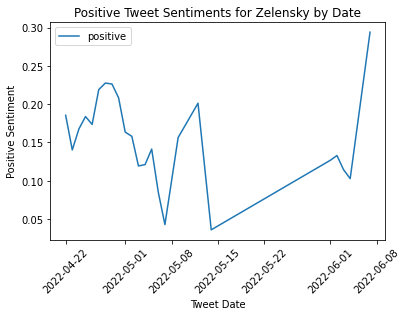

In [31]:
# Visualize positive tweet sentiment for Zelensky by date
# get dates in the dataframe 
dates = positive_for_zelensky["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
positive_zelensky_by_date =  positive_for_zelensky.groupby([positive_for_zelensky['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_zelensky_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Zelensky by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

In [32]:
# Analysis for Putin word
putin_df = tweets_df[tweets_df['cleaned_text'].str.contains('putin')]
putin_df.head(5)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive
78,bernieshq,8694,8490,132004,2008-10-09,2022-04-22,0,"[{'text': 'Ukraine', 'indices': [49, 57]}, {'t...",en,0,2022-04-22,False,False,16,ukrainian citizens celebrating the liberation ...,-0.143590,0.817667,0.038744
109,triplenickel,3073,3304,102163,2008-03-31,2022-04-22,0,"[{'text': 'Putin', 'indices': [131, 137]}]",en,0,2022-04-22,False,False,16,putin claims he makes 140000 and has an square...,-0.839323,0.157467,0.003210
123,csgazette,2742,67915,195464,2008-01-29,2022-04-22,0,"[{'text': 'RussiaUkrainewar', 'indices': [166,...",en,1,2022-04-22,False,False,16,russian president vladimir putin is claiming c...,-0.853577,0.141560,0.004862
128,jazzaoxon,5015,4658,366248,2008-04-23,2022-04-22,1,"[{'text': 'EU', 'indices': [33, 36]}, {'text':...",en,0,2022-04-22,True,False,16,good morning have a nice day get vaccinated on...,-0.595595,0.383448,0.020957
130,vinylzone,264,163,1429,2008-09-10,2022-04-22,0,"[{'text': 'StopPutin', 'indices': [242, 252]},...",en,0,2022-04-22,False,False,16,it is time to knock some sense into russia the...,-0.861086,0.133073,0.005841


In [33]:
# Extract negative score for Putin of twits and time, when they were created
negative_for_putin = putin_df[['tweetcreatedts', 'negative']]
negative_for_putin.head(5)

,tweetcreatedts,negative
78,2022-04-22,-0.143590
109,2022-04-22,-0.839323
123,2022-04-22,-0.853577
128,2022-04-22,-0.595595
130,2022-04-22,-0.861086


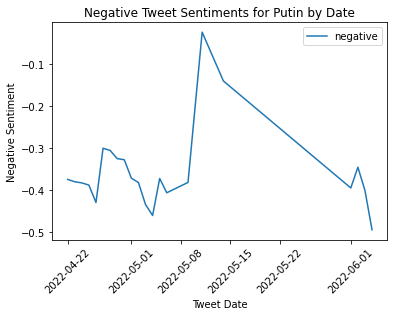

In [34]:
# Visualize negative tweet sentiment for Putin by date
# get dates in the dataframe 
dates = negative_for_putin["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
negative_putin_by_date =  negative_for_putin.groupby([negative_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
negative_putin_by_date.plot.line();

plt.title("Negative Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()

In [35]:
# Extract positive score for Putin of twits and time, when they were created
positive_for_putin = putin_df[['tweetcreatedts', 'positive']]
positive_for_putin.head(5)

,tweetcreatedts,positive
78,2022-04-22,0.038744
109,2022-04-22,0.003210
123,2022-04-22,0.004862
128,2022-04-22,0.020957
130,2022-04-22,0.005841


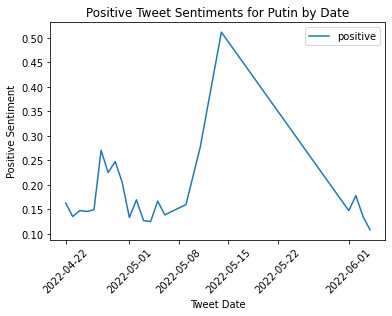

In [36]:
# Visualize positive tweet sentiment for Putin by date
# get dates in the dataframe 
dates = positive_for_putin["tweetcreatedts"].dt.day
# group tweet timestamps by date and get average negative score for each date
positive_putin_by_date =  positive_for_putin.groupby([positive_for_putin['tweetcreatedts'].dt.date]).mean()

# plot bar graph of tweet count by date
positive_putin_by_date.plot.line();

plt.title("Positive Tweet Sentiments for Putin by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
plt.show()

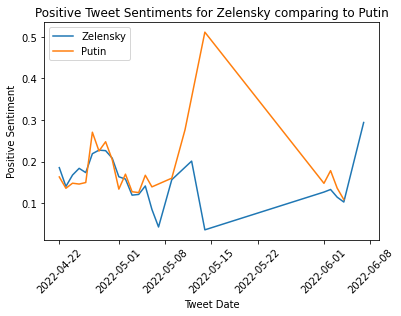

In [37]:
# The plot comparing positive score for Zelensky and Putin
ax = plt.subplot()
plt.title("Positive Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Positive Sentiment")
plt.xticks(rotation=45)
ax.plot(positive_zelensky_by_date['positive'], label='Zelensky')
ax.plot(positive_putin_by_date['positive'], label='Putin')
plt.legend(loc="upper left")
plt.show()

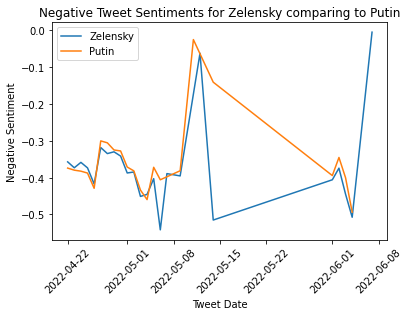

In [38]:
# The plot comparing negative score for Zelensky and Putin
ax = plt.subplot()
plt.title("Negative Tweet Sentiments for Zelensky comparing to Putin")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
ax.plot(negative_zelensky_by_date['negative'], label='Zelensky')
ax.plot(negative_putin_by_date['negative'], label='Putin')
plt.legend(loc="upper left")
plt.show()

**Get our transformed raw data into our database**

In [41]:
# Convert Pandas dataframe to Spark
tweets_df = spark.createDataFrame(tweets_df) 
tweets_df.printSchema()
tweets_df.show()

root
 |-- username: string (nullable = true)
 |-- following: long (nullable = true)
 |-- followers: long (nullable = true)
 |-- totaltweets: long (nullable = true)
 |-- usercreatedts: timestamp (nullable = true)
 |-- tweetcreatedts: timestamp (nullable = true)
 |-- retweetcount: long (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- language: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- extractedts: timestamp (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- is_quote_status: boolean (nullable = true)
 |-- weekofyear: long (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- negative: double (nullable = true)
 |-- neutral: double (nullable = true)
 |-- positive: double (nullable = true)

+-------------+---------+---------+-----------+-------------------+-------------------+------------+--------------------+--------+--------------+-------------------+----------+---------------+----------+--------------------+--------

In [39]:
# Store environmental variable
from getpass import getpass
password = getpass('password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://tweets.cnzbbvrrhst7.us-west-1.rds.amazonaws.com:5432/postgres"
config = {"user":"uatweets",
          "password": password,
          "driver":"org.postgresql.Driver"}

password··········


In [42]:
# Write DataFrame to active_user table in RDS
tweets_df.write.jdbc(url=jdbc_url, table='twitter_sentiments.csv', mode=mode, properties=config)

Py4JJavaError: ignored

In [ ]:
# Saving the data
file_path = "/Users/olgapodolska/Desktop/UA_War_my/resources/twitter_sentiments.csv"
tweets_df.to_csv(file_path, index=False)